## Chapter 21 Binary Classification Machine Learning Case Study Project

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

#### 1. Problem Definition

The focus of this project will be the Sonar Mines vs Rocks dataset. The problem is to predict metal or rock objects from sonar return data. Each pattern is a set of 60 numbers in the range
0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time. The label associated with each record contains the letter R if
the object is a rock and M if it is a mine (metal cylinder). The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.

#### 2. Load the Dataset

In [4]:
# load the dataset
filename = 'data/sonar.all-data.csv'
df = pd.read_csv(filename, header=None)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


#### 2. Analyze Data

##### (1) Descriptive Statistics

In [6]:
# shape
df.shape

(208, 61)

In [7]:
# types
df.dtypes

,0
0,float64
1,float64
2,float64
3,float64
4,float64
...,...
56,float64
57,float64
58,float64
59,float64


In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [10]:
# description
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

In [11]:
# class distribution
df[60].value_counts()

,count
60,
M,111
R,97


##### (2) Unimodal Data Visualizations

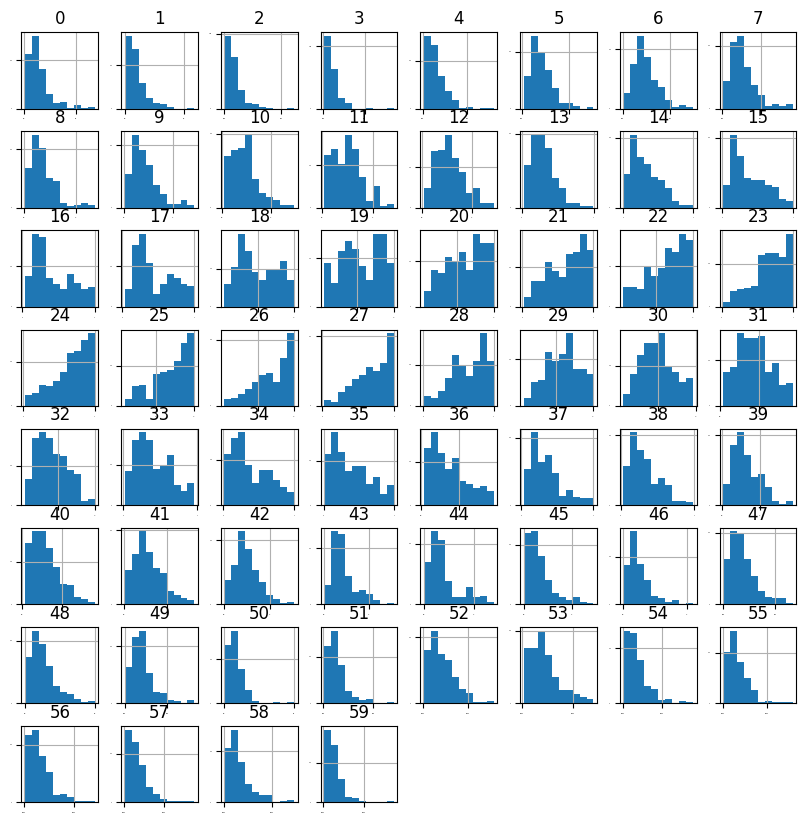

In [13]:
# histograms
df.hist(sharex=False, sharey=False, figsize=(10,10), xlabelsize=1, ylabelsize=1)
plt.show()

We can see that there are a lot of Gaussian-like distributions and perhaps some exponential-like distributions for other attributes.

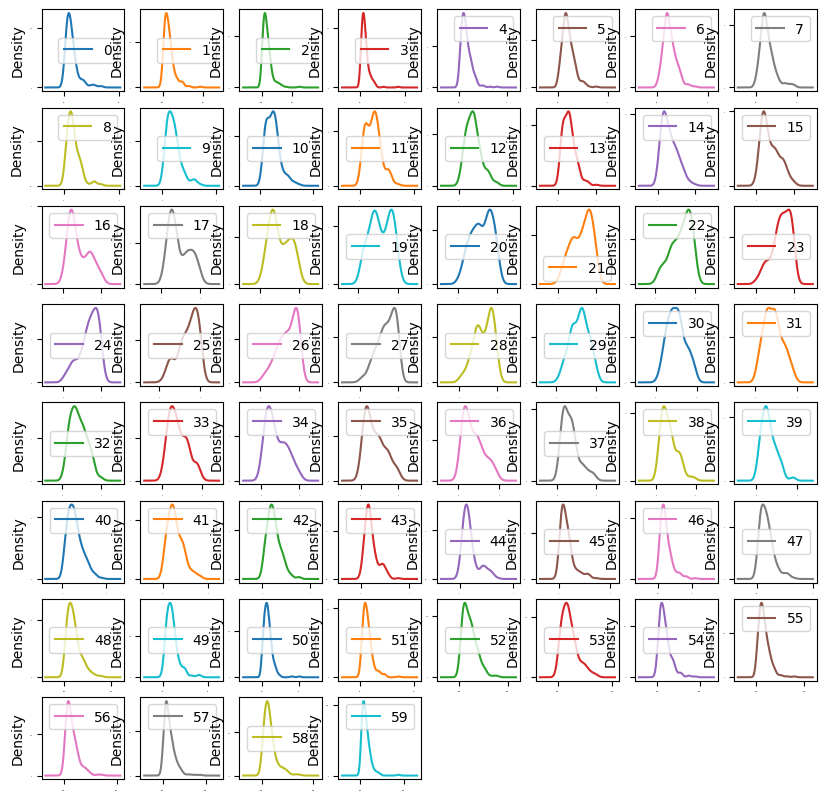

In [15]:
# density
df.plot(kind='density', subplots=True, layout=(8,8), figsize=(10,10), sharex=False, sharey=False, fontsize=1)
plt.show()

You can see that many of the attributes have a skewed distribution. A power transform like a Box-Cox transform that can correct for the skew in distributions might be useful.

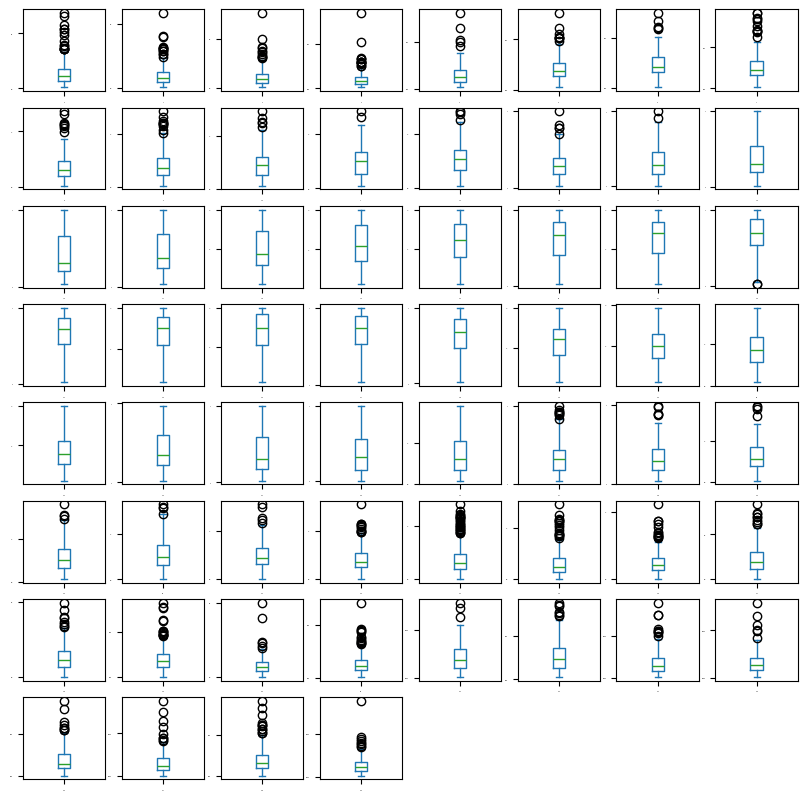

In [16]:
# box and whisker plots
df.plot(kind='box', subplots=True, layout=(8,8), figsize=(10,10), sharex=False, sharey=False, fontsize=1)
plt.show()

We can see that attributes do have quite diﬀerent spreads. Given the scales are the same, it may suggest some benefit in standardizing the data for modeling to get all of the means lined up.

##### (3) Multimodal Data Visualizations

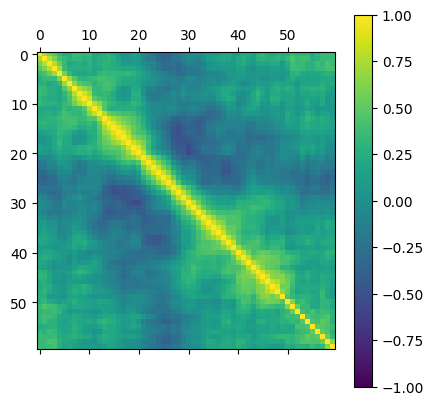

In [27]:
# correlation
plt.matshow(df.iloc[:,:-1].corr(), vmin=-1, vmax=1, interpolation='none')
plt.colorbar()
plt.show()

#### 4. Validation Dataset

It is a good idea to use a validation hold-out set. This is a sample of the data that we hold back from our analysis and modeling. We use it right at the end of our project to confirm the accuracy of our final model. It is a smoke test that we can use to see if we messed up and to give us confidence on our estimates of accuracy on unseen data. We will use 80% of the dataset for modeling and hold back 20% for validation.

In [30]:
# split out validation dataset
array = df.values
X = array[:,:-1].astype(float)
Y = array[:,-1]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#### 5. Evaluate Algorithms: Baseline

In [31]:
# test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

In [33]:
# spot check algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f'{name}: mean: {cv_results.mean()}, std: ({cv_results.std()})')

LR: mean: 0.7716911764705883, std: (0.091002116263084)
LDA: mean: 0.7786764705882352, std: (0.09357032956228412)
KNN: mean: 0.7588235294117647, std: (0.1064171542874719)
CART: mean: 0.7698529411764705, std: (0.11091979395960631)
NB: mean: 0.6827205882352941, std: (0.13603984459197604)
SVM: mean: 0.7650735294117647, std: (0.0875193070641932)


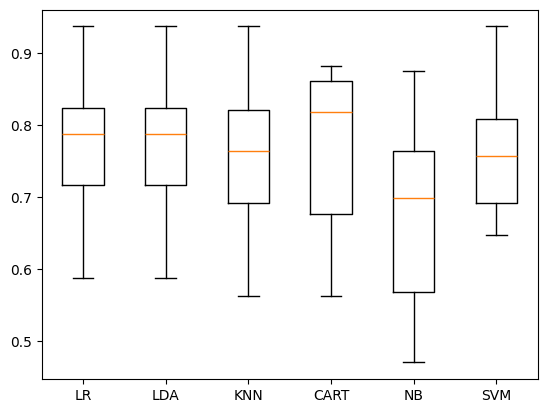

In [36]:
# compare algorithms
plt.figure()
plt.boxplot(results, tick_labels=names)
plt.show()

#### 6. Evaluate Algorithms: Standardize Data

This is where the data is transformed such that each attribute has a mean value of zero and a standard deviation of one. We also need to avoid data leakage when we transform the data. A good way to avoid leakage is to use pipelines that standardize the data and build the
model for each fold in the cross validation test harness.

In [37]:
# standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f'{name}: mean: {cv_results.mean()}, std: ({cv_results.std()})')

ScaledLR: mean: 0.7544117647058824, std: (0.06792621429341761)
ScaledLDA: mean: 0.7786764705882352, std: (0.09357032956228412)
ScaledKNN: mean: 0.8084558823529411, std: (0.10799628441801545)
ScaledCART: mean: 0.7040441176470588, std: (0.10915155747858112)
ScaledNB: mean: 0.6827205882352941, std: (0.13603984459197604)
ScaledSVM: mean: 0.8261029411764707, std: (0.08181365573488257)


We can see that both KNN and SVM perform better than before. We can also see that the standardization of the data has lifted
the skill of SVM to be the most accurate algorithm tested so far.

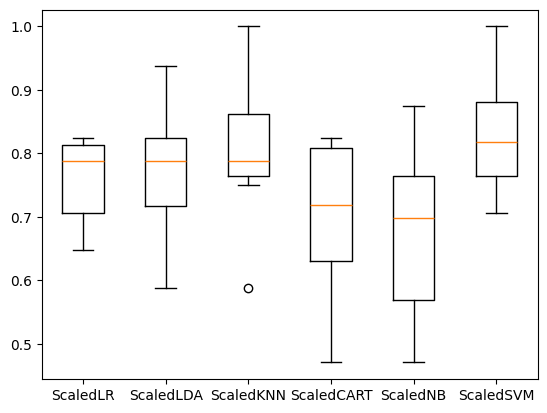

In [38]:
# compare algorithms
plt.figure()
plt.boxplot(results, tick_labels=names)
plt.show()

The results suggest digging deeper into the SVM and KNN algorithms. It is very likely that configuration beyond the default may yield even more accurate models.

#### 7. Algorithm Tuning

##### (1) Tuning KNN

We can start oﬀ by tuning the number of neighbors for KNN. The default number of neighbors is 7.

In [41]:
# tune scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, params in zip(means, stds, params):
  print(f"{mean} ({stdev}) with: {params}")

Best: 0.8360294117647058 using {'n_neighbors': 1}
0.8360294117647058 (0.0794866204928241) with: {'n_neighbors': 1}
0.8136029411764707 (0.08802133986497988) with: {'n_neighbors': 3}
0.8143382352941178 (0.09686994210481911) with: {'n_neighbors': 5}
0.7775735294117647 (0.12038687007377162) with: {'n_neighbors': 7}
0.7301470588235294 (0.09937629892951001) with: {'n_neighbors': 9}
0.7415441176470589 (0.07397018623443563) with: {'n_neighbors': 11}
0.7106617647058824 (0.10582936276143473) with: {'n_neighbors': 13}
0.7231617647058823 (0.08098339277187816) with: {'n_neighbors': 15}
0.6988970588235295 (0.07266867533836381) with: {'n_neighbors': 17}
0.7106617647058824 (0.09133717455131453) with: {'n_neighbors': 19}
0.6988970588235295 (0.09119499930327252) with: {'n_neighbors': 21}


##### (2) Tuning SVM

We can tune two key parameters of the SVM algorithm, the value of C (how much to relax the margin) and the type of kernel. The default for SVM (the SVC class) is to use the Radial Basis Function (RBF) kernel with a C value set to 1.0.

In [42]:
# tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, params in zip(means, stds, params):
  print(f"{mean} ({stdev}) with: {params}")

Best: 0.85 using {'C': 1.7, 'kernel': 'rbf'}
0.7485294117647059 (0.06995348800759733) with: {'C': 0.1, 'kernel': 'linear'}
0.5827205882352942 (0.1270618233918742) with: {'C': 0.1, 'kernel': 'poly'}
0.6011029411764707 (0.18443464594421374) with: {'C': 0.1, 'kernel': 'rbf'}
0.7128676470588236 (0.11657890555209026) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.7544117647058824 (0.08233652672549402) with: {'C': 0.3, 'kernel': 'linear'}
0.6441176470588236 (0.09987286468478822) with: {'C': 0.3, 'kernel': 'poly'}
0.742279411764706 (0.08185329653703163) with: {'C': 0.3, 'kernel': 'rbf'}
0.7485294117647059 (0.06995348800759733) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.7658088235294118 (0.07033598464011231) with: {'C': 0.5, 'kernel': 'linear'}
0.7047794117647059 (0.09822508422638421) with: {'C': 0.5, 'kernel': 'poly'}
0.7845588235294118 (0.06892181267912051) with: {'C': 0.5, 'kernel': 'rbf'}
0.7606617647058824 (0.06563195094181692) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.7599264705882354 (0.08320609158

We can see the most accurate configuration was SVM with an RBF kernel and a C value of 1.7. The accuracy 85% is seemingly better than what KNN could achieve.

#### 8. Ensemble Methods

Another way that we can improve the performance of algorithms on this problem is by using ensemble methods. Next we will evaluate four diﬀerent ensemble machine learning
algorithms, two boosting and two bagging methods:
- Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM)
- Bagging Methods: Random Forecasts (RF) and Extra Trees (ET)

In [43]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))

results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f'{name}: mean: {cv_results.mean()}, std: ({cv_results.std()})')

AB: mean: 0.8018382352941178, std: (0.08730282405647193)
GBM: mean: 0.8018382352941176, std: (0.10484646976977047)
RF: mean: 0.8316176470588236, std: (0.11387329813297611)
ET: mean: 0.8742647058823529, std: (0.09042623023319533)


We can see that both boosting techniques provide strong accuracy scores in the low 80s (%) with default configurations.

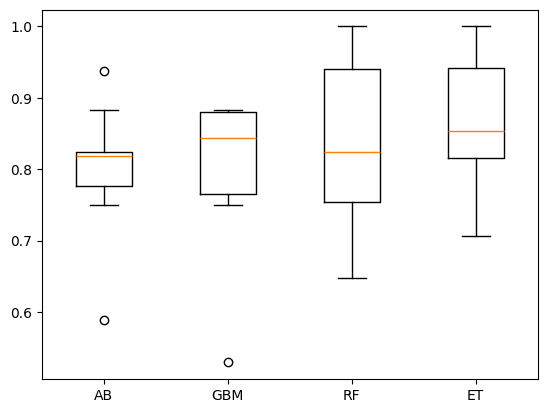

In [44]:
# compare algorithms
plt.figure()
plt.boxplot(results, tick_labels=names)
plt.show()

#### Finalize Model

The SVM showed the most promise as a low complexity and stable model for this problem. In this section we will finalize the model by training it on the entire training dataset and make predictions for the hold-out validation dataset to confirm our findings. A part of the findings was that SVM performs better when the dataset is standardized so that all attributes have a mean
value of zero and a standard deviation of one.

In [45]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(C=1.7)
model.fit(rescaledX, Y_train)
# estimate accuracy on valiation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9285714285714286
[[25  2]
 [ 1 14]]
              precision    recall  f1-score   support

           M       0.96      0.93      0.94        27
           R       0.88      0.93      0.90        15

    accuracy                           0.93        42
   macro avg       0.92      0.93      0.92        42
weighted avg       0.93      0.93      0.93        42

